In [2]:
import os
import tempfile

import numpy as np
import requests
import scanpy as sc
import scvi
import seaborn as sns
import torch

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.6


# Import Data

In [4]:
adata = sc.read("/data/rudensky/EYW/SIG04_240816/python_outs/SIG04_merge_singlets_SCT_scanpy.h5ad")

For reference, plot the UMAP of perturbed cells based on pearson residuals

/home/wange7/miniforge3/envs/scvi/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


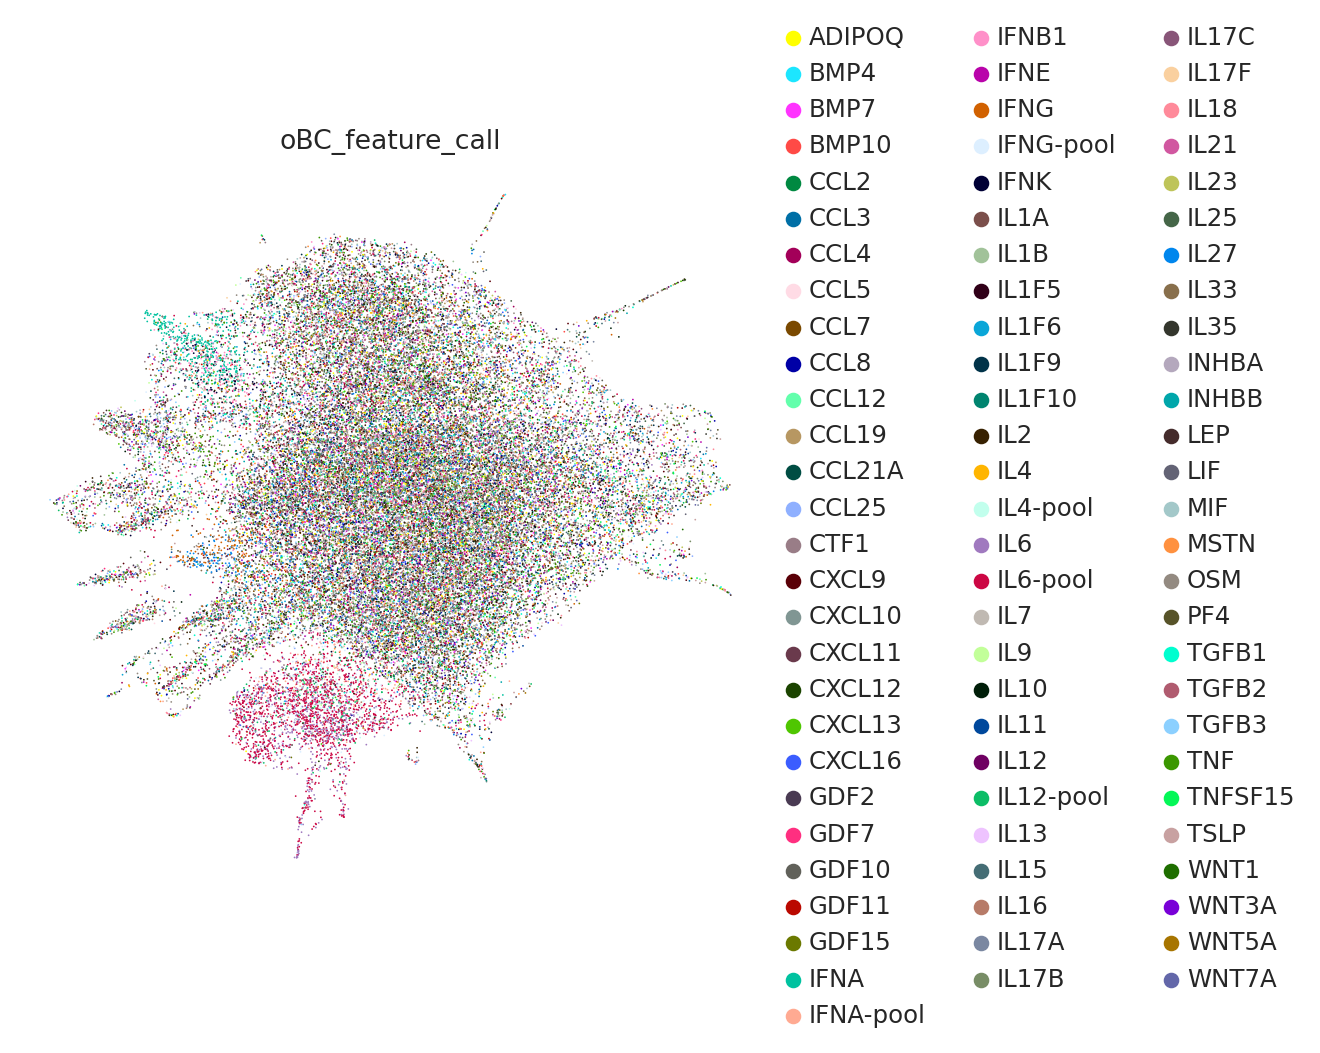

In [10]:
perturbed_adata = adata[adata.obs["oBC_feature_call"] != "p129"]  # Only consider perturbed cells

sc.pp.pca(perturbed_adata)
sc.pp.neighbors(perturbed_adata)
sc.tl.umap(perturbed_adata)
sc.pl.umap(perturbed_adata, color=["oBC_feature_call"])

# Run Model

In [5]:
# set up model anndata (including covariates)
scvi.external.ContrastiveVI.setup_anndata(adata,
                                          layer="counts",
                                          batch_key="gem_group")

# set up model
contrastive_vi_model = scvi.external.ContrastiveVI(
    adata, n_salient_latent=10, n_background_latent=10, use_observed_lib_size=False
)

# setup control and perturbed indices
background_indices = np.where(adata.obs["oBC_feature_call"] == "p129")[0]
target_indices = np.where(adata.obs["oBC_feature_call"] != "p129")[0]

In [ ]:
contrastive_vi_model.train(
    background_indices=background_indices,
    target_indices=target_indices,
    early_stopping=True,
    max_epochs=500
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wange7/miniforge3/envs/scvi-gpu/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/wange7/miniforge3/envs/scvi-gpu/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

/home/wange7/miniforge3/envs/scvi-gpu/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 73. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 2/500:   0%|          | 1/500 [00:20<2:48:52, 20.30s/it, v_num=1, train_loss_step=2.72e+4, train_loss_epoch=6.95e+4]

/home/wange7/miniforge3/envs/scvi-gpu/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 11/500:   2%|▏         | 10/500 [02:30<1:59:18, 14.61s/it, v_num=1, train_loss_step=2.17e+4, train_loss_epoch=2.18e+4]